# Produce Cached `galaxy_ids` for DC2

_Last Updated: Bryce Kalmbach, August 2018_

This is a notebook to produce the cached AGN and SN galaxy_id lists for DC2 Run 2. In this notebook we match the source AGN and SNe galaxies to objects in the galaxy catalogs.

In [21]:
import pandas as pd
from astropy.io import fits
import numpy as np
from desc.sims.GCRCatSimInterface import InstanceCatalogWriter
from lsst.sims.utils import SpecMap
import matplotlib.pyplot as plt
from lsst.utils import getPackageDir
from lsst.sims.photUtils import Sed, BandpassDict, Bandpass
from lsst.sims.catUtils.matchSED import matchBase
%matplotlib inline

### Create an unsprinkled Instance Catalog 

This is to get the possible AGN and Bulge galaxies to replace with the sprinkler

**NOTE: Just to show proof of concept for review I have used protoDC2 here even though I created new OM10 and GLSNe catalogs with cosmoDC2. That means that some issues due to redshift in protoDC2 being cutoff at z=1 are present but I have noted those below.**

In [2]:
# First we need to create a catalog without sprinkling
opsimDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
agnDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/agn_db_mbh_7.0_m_i_30.0_gcr_protodc2_v3.db'

t_sky = InstanceCatalogWriter(opsimDB, 'proto-dc2_v3.0', min_mag=30, protoDC2_ra=55.064,
                              protoDC2_dec=-29.783, sprinkler=False,
                              agn_db_name=agnDB)

In [3]:
uddf_visit = 197356 # Use a visit we know covers the uDDF field
t_sky.write_catalog(uddf_visit, fov=1.4)

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.19_sim2.8.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_catUtils/2.8.0.sims/python/lsst/sims/catUtils/mixins/VariabilityMixin.py:852: RuntimeWarning: divide by zero encountered in true_divide
  dd = _au_to_parsec/parallax
/global/homes/b/brycek/DC2/gcr-catalogs/GCRCatalogs/alphaq.py:40: RuntimeWarning: divide by zero encountered in true_divide
  Rv = np.log10(v) / np.log10(bv)
/global/homes/b/brycek/DC2/gcr-catalogs/GCRCatalogs/alphaq.py:40: RuntimeWarning: invalid value encountered in true_divide
  Rv = np.log10(v) / np.log10(bv)
/global/homes/b/brycek/DC2/gcr-catalogs/GCRCatalogs/alphaq.py:47: RuntimeWarning: divide by zero encountered in log10
  Av = -2.5*(np.log10(lum_v_dust/lum_v))
/global/homes/b/brycek/DC2/gcr-catalogs/GCRCatalogs/alphaq.py:39: RuntimeWarning: divide by zero encountered in true_divide
  bv = b/v
/global/homes/b/brycek/DC2/gcr-catalogs/GCRCatalogs/alphaq.py:39: RuntimeWarning: invalid value encountered i

### Load in the AGN and Bulge catalogs as dataframes

In [4]:
base_columns = ['prefix', 'uniqueId', 'raPhoSim', 'decPhoSim',
                        'phosimMagNorm', 'sedFilepath', 'redshift',
                        'shear1', 'shear2', 'kappa', 'raOffset', 'decOffset',
                        'spatialmodel']
df_galaxy = pd.read_csv('bulge_gal_cat_197356.txt.gz',
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])
df_agn = pd.read_csv('agn_gal_cat_197356.txt.gz',
                                 delimiter=' ', header=None,
                                 names=base_columns+['internalExtinctionModel',
                                                     'galacticExtinctionModel',
                                                     'galacticAv', 'galacticRv'])


In [5]:
df_agn['galaxy_id'] = np.right_shift(df_agn['uniqueId'], 10)

In [6]:
df_agn.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,raOffset,decOffset,spatialmodel,internalExtinctionModel,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,31861,53.759628,-27.624302,22.602996,agnSED/agn.spec.gz,0.015663,-0.000000,0.000000,0.000000,0,0,point,none,CCM,0.028854,3.1,31
1,object,99445,54.571807,-28.040336,26.044621,agnSED/agn.spec.gz,0.023573,-0.000000,0.000000,0.000000,0,0,point,none,CCM,0.030606,3.1,97
2,object,101493,54.875131,-28.087258,26.163638,agnSED/agn.spec.gz,0.023740,-0.000000,0.000000,0.000000,0,0,point,none,CCM,0.041117,3.1,99
3,object,261237,54.876707,-28.084598,21.276648,agnSED/agn.spec.gz,0.024828,0.000013,-0.000007,0.000234,0,0,point,none,CCM,0.041269,3.1,255
4,object,263285,54.532179,-27.748710,21.732387,agnSED/agn.spec.gz,0.024660,0.000017,0.000012,0.000028,0,0,point,none,CCM,0.035498,3.1,257


### Match the AGN catalog to Twinkles systems

We will go through the AGN catalog and find AGN in the uDDF field that match our properties. We will then save the `galaxy_id` of these AGN and give the corresponding OM10 system a `twinklesId` in the catalog that identifies it with this AGN when the sprinkler runs.

In [8]:
# Load in OM10 lenses we are using in Twinkles

from astropy.io import fits
hdulist = fits.open('../../data/twinkles_lenses_cosmoDC2_v0.1.fits')
twinkles_lenses = hdulist[1].data

In [46]:
# Convert phosimMagNorm to i-band magnitudes for the uDDF AGN
bpDict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames=['i'])
bp = Bandpass()
imsimBand = bp.imsimBandpass()
agn_fname = str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz')

src_iband = []
src_mag_norm = df_agn['phosimMagNorm'].values
src_z = df_agn['redshift'].values

for src_mag, s_z in zip(src_mag_norm, src_z):
    agn_sed = Sed()
    agn_sed.readSED_flambda(agn_fname)
    agn_sed.redshiftSED(s_z, dimming=True)
    f_norm = agn_sed.calcFluxNorm(src_mag, bp)
    agn_sed.multiplyFluxNorm(f_norm)
    src_iband.append(agn_sed.calcMag(bpDict['i']))

In [50]:
df_agn['i_magnitude'] = src_iband

We want to match the AGN in the uDDF field to lensed systems based upon the redshift and magnitude of the source AGN. In this example we use 0.1 dex in redshift and 0.25 mags in the _i_-band. This doesn't get us to ~1000 systems like we want but that's ok for this example since `protoDC2` only went out to redshift=1.0. Hopefully with `cosmoDC2` these bounds will get us plenty of systems. **(Anytime you use a new catalog this may need to be played with to get the desired number of systems)**

In [62]:
def find_agn_lens_candidates(galz, gal_mag):
        # search the OM10 catalog for all sources +- 0.1 dex in redshift                                                                                               
        # and within .25 mags of the AGN source                                                                                                                     
    w = np.where((np.abs(np.log10(twinkles_lenses['ZSRC']) - np.log10(galz)) <= 0.1) &
                     (np.abs(twinkles_lenses['MAGI_IN'] - gal_mag) <= .25))[0]
    lens_candidates = twinkles_lenses[w]

    return lens_candidates

In [93]:
%%time
density_param = 1.0
good_rows = []
ra_list = []
dec_list = []
gal_ids = []
catalog_row_num = []
catalog_ids = []
for idx, row in df_agn.iterrows():
    if idx % 5000 == 0:
        print(idx)
    #if (52.495 < row['raJ2000'] < 53.755) and (-28.65 < row['decJ2000'] < -27.55):
    if (52.495 < row['raPhoSim'] < 53.755) and (-28.65 < row['decPhoSim'] < -27.55):
        candidates = find_agn_lens_candidates(row['redshift'], row['i_magnitude'])
        np.random.seed(np.int(row['galaxy_id']))
        keep_idx = []
        if len(candidates) > 0:
            for candidate_idx, candidate_sys in list(enumerate(candidates['LENSID'])):
                if candidate_sys not in catalog_ids:
                    keep_idx.append(candidate_idx)
            if len(keep_idx) == 0:
                continue
            else:
                candidates = candidates[keep_idx]
        pick_value = np.random.uniform()
        if ((len(candidates) > 0) and (pick_value <= density_param)):
            good_rows.append(idx)
            gal_ids.append(row['galaxy_id'])
            newlens = np.random.choice(candidates)
            catalog_ids.append(newlens['LENSID'])
            catalog_row_num.append(np.where(twinkles_lenses['LENSID'] == newlens['LENSID'])[0][0])
            ra_list.append(row['raPhoSim'])
            dec_list.append(row['decPhoSim'])

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [98]:
print(catalog_row_num[:10], gal_ids[:10])

[7807, 4792, 11303, 13727, 9525, 8954, 2492, 702, 10710, 4295] [244234, 281703, 668658, 762504, 881469, 1019131, 1020008, 1020550, 1136803, 1137428]


In [95]:
len(good_rows), len(np.unique(good_rows)), len(np.unique(catalog_ids)), len(np.unique(catalog_row_num))

(280, 280, 280, 280)

In [96]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

Check to see that our cached systems are distributed throughout the uDDF field.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


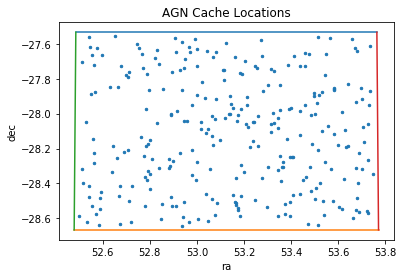

In [97]:
plt.scatter(ra_list, dec_list, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel(r'ra')
plt.ylabel(r'dec')
plt.title('AGN Cache Locations')
#plt.savefig('agn_cache.png')

In [101]:
catalog_row_sort = np.argsort(catalog_row_num)
catalog_row_num = np.array(catalog_row_num)

In [113]:
# Add in Twinkles ID Number to catalog for matched objects
col_list = []
for col in twinkles_lenses.columns:
        col_list.append(fits.Column(name=col.name, format=col.format, array=twinkles_lenses[col.name][catalog_row_num[catalog_row_sort]]))
col_list.append(fits.Column(name='twinklesId', format='I', array=np.arange(len(good_rows))))

In [115]:
cols = fits.ColDefs(col_list)
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('../../data/cosmoDC2_v0.1_test_matched_AGN.fits')

In [117]:
tbhdu.data[:5]

FITS_rec([ ( 115074, 0, 2,  0.128,  113.5011,  0.2432515,  153.0029 ,  0.07510341,  122.0065 ,  1.06, -0.1656299 ,  0.1122722 ,  23.19,  23.11888,  0.6968272, [ 0.1132, -0.4384,  0.    ,  0.    ], [-0.0756,  0.3502,  0.    ,  0.    ], [ -1.0677,   1.8956,   0.    ,   0.    ], [  2.387,   0.   ,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  471.641754,   600.109436, -20.6982002,  18.3209515,  0.12800001,  1673.38,  1415.12,  0.,  7101.16,  0.,  1.63989151,  0., 'galaxySED/Exp.62E09.1Z.spec.gz',  17.99147028, 0),
          ( 284363, 0, 2,  0.174,  129.4196,  0.4736329, -134.9654 ,  0.08003578, -164.6348 ,  0.68,  0.1632614 ,  0.00989747,  21.03,  21.34235,  0.706072 , [-0.1602,  0.5356,  0.    ,  0.    ], [ 0.0663,  0.1863,  0.    ,  0.    ], [ -0.75  ,   1.8237,   0.    ,   0.    ], [  3.666,   0.   ,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  609.13324 ,   839.553772, -21.0769806,  18.7172623,  0.17399999,  1456.65,  1030.98,  0.,  4111.25,  0.,  

Save the cached `galaxy_id` info to file

In [108]:
agn_cache = pd.DataFrame(np.array([np.array(gal_ids)[catalog_row_sort], np.arange(len(good_rows))], dtype=np.int).T,
                         columns=['galtileid', 'twinkles_system'])

In [109]:
agn_cache.head()

,galtileid,twinkles_system
0,7358147,0
1,2721181,1
2,7093431,2
3,6636773,3
4,9167952,4


In [129]:
#Check that galaxy_ids and twinkles_ids in FITS match up after sort
g_id = np.where(np.array(gal_ids) == agn_cache['galtileid'].values[0])
print(np.array(catalog_ids)[g_id] == tbhdu.data['LENSID'][0])

[ True]


In [130]:
agn_cache.to_csv('dc2_agn_cache.csv', index=False)

### Match to GLSNe catalog

Here we do the same as we did for the AGN and OM10 catalog except with a bulge galaxy catalog and the host galaxy information from the Gravitationally Lensed SNe catalog.

In [141]:
sne_catalog = pd.read_csv('../../data/cosmoDC2_v0.1_sne_cat.csv')

In [132]:
df_galaxy['galaxy_id'] = np.right_shift(df_galaxy['uniqueId'], 10)

In [184]:
use_gals_df = df_galaxy.query('raPhoSim > 52.495 and raPhoSim < 53.755 and decPhoSim > -28.65 and decPhoSim < -27.55')

As we did before we match based upon a property in each catalog. Here we use the source redshift of the SNe in the lens catalog and the redshift of the potential host galaxies in the uDDF field. Since we have so many potential host galaxies we tighten up the redshift bounds to 0.01 in dex.

In [221]:
def find_sne_lens_candidates(galz):#, gal_mag):
    # search the galaxy catalog for all possible host galaxies +- 0.01 dex in redshift

    lens_candidates = use_gals_df.query(str('redshift < {}'.format(np.power(10, np.log10(galz)+0.01)) + ' and ' +
                                            'redshift > {}'.format(np.power(10, np.log10(galz)-0.01))))
    if len(lens_candidates) == 0:
        print(galz)

    return lens_candidates

In [224]:
%%time
sne_density = 1.0
good_rows_sn = []
gal_ids_sn = []
sys_ids_sn = []
used_systems = []
ra_list_sn = []
dec_list_sn = []
total_unique_sys = len(np.unique(sne_catalog['twinkles_sysno']))

for idx, row in sne_catalog.iterrows():
    
        if idx % 100 == 0:
            print(idx)
    
        if row['twinkles_sysno'] in sys_ids_sn:
            continue
    
        lens_sne_candidates = find_sne_lens_candidates(row['zs'])
        candidate_indices = lens_sne_candidates.index.values
        keep_indices = []
        for value in np.random.choice(candidate_indices, size=1000, replace=False):
            if (value not in sys_ids_sn):
                keep_indices.append(value)
        
        choices = np.random.choice(keep_indices, size=5, replace=False)
        
        for i in choices:
            if df_galaxy['galaxy_id'].iloc[i] not in df_agn:
                choice = i
                continue
        
        sys_ids_sn.append(row['twinkles_sysno'])
        gal_ids_sn.append(df_galaxy['galaxy_id'].iloc[choice])
        ra_list_sn.append(df_galaxy['raPhoSim'].iloc[choice])
        dec_list_sn.append(df_galaxy['decPhoSim'].iloc[choice])
        good_rows_sn.append(choice)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
CPU times: user 1min 4s, sys: 84.2 ms, total: 1min 4s
Wall time: 1min 4s


**The discrepancy below is due to protoDC2 only going out to z=1 in redshift.**

In [225]:
len(good_rows_sn), len(ra_list_sn), total_unique_sys

(930, 930, 966)

Once again check to see that we are spread throught uDDF region.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


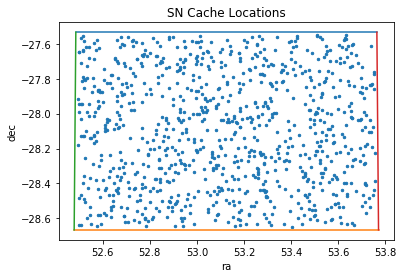

In [228]:
plt.scatter(ra_list_sn, dec_list_sn, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('SN Cache Locations')
#plt.savefig('sne_cache.png')

Save the cache of `galaxy_ids` and associated `twinklesId` values to file.

In [229]:
sne_cache = pd.DataFrame(np.array([gal_ids_sn, sys_ids_sn], dtype=np.int).T, columns=['galtileid', 'twinkles_system'])

In [230]:
sne_cache.to_csv('dc2_sne_cache.csv', index=False)